In [1]:
#Colab Setup
%tensorflow_version 2.x

from google.colab import drive
drive.mount('/content/gdrive')

!pip install pymorphy2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append("/content/gdrive/My Drive/smu-ABAE/classes")

review_corpus_path = "/content/gdrive/My Drive/smu-ABAE/data/tech_review_sent_corpus.pkl"
vocab_path = "/content/gdrive/My Drive/smu-ABAE/data/vocab-text-review.txt"
emb_filename = '/content/gdrive/My Drive/smu-ABAE/models/w2v_embedding'
aspect_output_path = '/content/gdrive/My Drive/smu-ABAE/results/ABAE'
stop_words_path = "/content/gdrive/My Drive/smu-ABAE/data/stop_words.json"

In [0]:
# import sys
# import os

# module_path = os.path.abspath(os.path.join(".."))
# if module_path not in sys.path:
#     sys.path.append(module_path+"/scripts")
#     sys.path.append(module_path+"/classes")

# review_corpus_path = "../data/tech_review_sent_corpus.pkl"
# vocab_path = "../data/glove-tech-revew-vocab.txt"
# emb_filename = '../models/w2v_embedding'
# aspect_output_path = "../results/ABAE"
# vocab_path = "../data/vocab-text-review.txt"


In [4]:
import pandas as pd
import pickle

with open(review_corpus_path,"rb") as f:
    tech_review_corpus = pickle.load(f)

print(len(tech_review_corpus))
display(pd.DataFrame(tech_review_corpus).head(10))

156988


,index,review
0,299,fluor is a great company with people that care...
1,299,management care about their employee a well a ...
2,1145,fluor wa the first powerhouse epc that went he...
3,1145,they send a much work overseas a possible and ...
4,1145,this is a heavy loaded company with management
5,1145,fluor chase the big project and will hire thou...
6,1145,in turn they will lay off thousand when it s g...
7,1145,fluor ha the sharpest spike in hiring and layi...
8,1145,the employee is clearly not their great asset
9,1375,there is not much that i could add here


## Parmeters

In [6]:
from numpy.random import seed
import tensorflow as tf
seed(76244)
tf.random.set_seed(76244)

import ABAE.utils as U
parser = U.add_common_args()

Using TensorFlow backend.


## Setup Data

100%|██████████| 156988/156988 [00:28<00:00, 5487.28it/s]


Max Character length 1237
Average Character Length 42.26510943511606
Standard Deviation 35.0334094854748
Median Character Length 35.0
Characters 2 standard deviations from mean 112.33192840606566


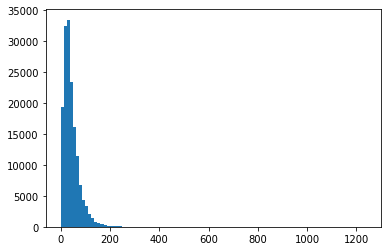

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
from multiprocessing import Pool

with open(stop_words_path, "r") as f:
  stop_words = json.load(f)

def removeStopWords(review):
  tokens = review.split(" ")
  return " ".join([ word for word in tokens if word not in stop_words ])

reviews = pd.DataFrame(tech_review_corpus).review.tolist()

with Pool() as p:
  reviews = list(tqdm(p.imap(removeStopWords, reviews), total=len(reviews)))

word_length = [ len(review) for review in reviews ]

print("Max Character length", max(word_length))
print("Average Character Length", np.mean(word_length))
print("Standard Deviation", np.std(word_length))
print("Median Character Length", np.median(word_length))
print("Characters 2 standard deviations from mean", np.mean(word_length) + (2*np.std(word_length)))

plt.hist(word_length,bins=100)
plt.show()

In [8]:
 from keras.preprocessing import sequence
import ABAE.reader as dataset

#Paramaters
maxlen = 115 #Based on 2 standard deviations from mean

vocab, train_x, overall_maxlen = dataset.get_data(reviews, vocab_path, vocab_size=0, maxlen=maxlen)
train_x = sequence.pad_sequences(train_x, maxlen=overall_maxlen)

vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w
    
# train_x = train_x[0:30000]
print('Number of training examples: ', len(train_x))
print('Length of vocab: ', len(vocab))

 Creating vocab ...
   963539 total words, 22093 unique words
 Reading dataset ...
  train set
Corpus Size 156988
Total Document Analyzed 148446
<num> hit rate: 1.22%, <unk> hit rate: 0.00%
Number of training examples:  148446
Length of vocab:  22096


In [8]:
print(reviews[20])
print( [ vocab_inv[i] for i in train_x[20]] )

infrastructure wa adequately maintain except maybe escalator
['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

## Attention-Based-Aspect-Detection Code

In [9]:
import importlib
# import ABAE.model
# import ABAE.w2vEmbReader
import ABAE.train
# import ABAE.reader
# importlib.reload(ABAE.model)
# importlib.reload(ABAE.w2vEmbReader)
importlib.reload(ABAE.train)
# importlib.reload(ABAE.reader)

<module 'ABAE.train' from '/content/gdrive/My Drive/smu-ABAE/classes/ABAE/train.py'>

In [10]:
import os
from ABAE.w2vEmbReader import W2VEmbReader as EmbReader

emb_reader = EmbReader(emb_filename)

2020-06-09 18:14:25,633 INFO Loading embeddings from: /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding
2020-06-09 18:14:25,634 INFO loading Word2VecKeyedVectors object from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-06-09 18:14:26,433 INFO loading wv recursively from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding.wv.* with mmap=None
2020-06-09 18:14:26,435 INFO setting ignored attribute vectors_norm to None
2020-06-09 18:14:26,436 INFO loading vocabulary recursively from /content/gdrive/My Drive/smu-ABAE/models/w2v_embedding.vocabulary.* with mmap=None
2020-06-09 18:14:26,440 INFO loading trainables recursiv

  #vectors: 44377, #dimensions: 200


In [0]:
import ABAE.model as m
from ABAE.optimizers import get_optimizer, sentence_batch_generator, negative_batch_generator
from ABAE.train import train
import itertools

neg_size = 20
emb_dim = 200
aspect_sizes = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
ortho_regs = [0.3, 0.5, 0.8, 1]
batch_size = 50
epochs = 15
import json

parameters = list(itertools.product(aspect_sizes, ortho_regs))

optimizer = get_optimizer("adam")

for param in parameters:
    k = param[0]
    ortho_reg = param[1]
    print("="*80)
    print("Running for k={0} and ortho_reg={1}".format(k, ortho_reg))
    
    aspect_file_name = "abae-k-{0}-orth-{1}".format(k, ortho_reg)
    aspect_file_name = os.path.join(aspect_output_path,aspect_file_name)

    if not os.path.isfile(aspect_file_name + ".json"):
      model = m.create_model(overall_maxlen, vocab, k, neg_size, emb_reader, ortho_reg)
      # freeze the word embedding layer
      model.get_layer('word_emb').trainable = False
      model.compile(optimizer=optimizer, loss=U.max_margin_loss, metrics=[U.max_margin_loss])

      sen_gen = sentence_batch_generator(train_x, batch_size)
      neg_gen = negative_batch_generator(train_x, batch_size, neg_size)
      batches_per_epoch = len(train_x) // batch_size

      aspect = train(model, sen_gen, neg_gen, epochs, batch_size, batches_per_epoch, aspect_file_name, vocab_inv)

      with open(aspect_file_name + ".json", "w") as f:
          json.dump(aspect, f)
          
    print("="*80)

Running for k=5 and ortho_reg=0.3
Initializing word embedding matrix


  0%|          | 0/15 [00:00<?, ?it/s]

17141/22096 word vectors initialized (hit rate: 77.58%)
Initializing aspect embedding matrix as centroid of kmean clusters


 40%|████      | 6/15 [03:30<05:17, 35.24s/it]

In [0]:
# k = 5
# ortho_reg = 0.8

# model = m.create_model(overall_maxlen, vocab, k, neg_size, emb_reader, ortho_reg)
# # freeze the word embedding layer
# model.get_layer('word_emb').trainable = False
# model.compile(optimizer=optimizer, loss=U.max_margin_loss, metrics=[U.max_margin_loss])

# sen_gen = sentence_batch_generator(train_x, batch_size)
# neg_gen = negative_batch_generator(train_x, batch_size, neg_size)
# batches_per_epoch = len(train_x) // batch_size

# min_loss = float('inf')
# for ii in range(epochs):
#     t0 = time()
#     loss, max_margin_loss = 0., 0.

#     # for b in tqdm(range(batches_per_epoch)):
#     for b in range(batches_per_epoch):
#         sen_input = next(sen_gen)
#         neg_input = next(neg_gen)

#         batch_loss, batch_max_margin_loss = model.train_on_batch([sen_input, neg_input],
#                                                                 np.ones((batch_size, 1)))
#         loss += batch_loss / batches_per_epoch
#         max_margin_loss += batch_max_margin_loss / batches_per_epoch

#     tr_time = time() - t0

#     if loss < min_loss:
#         min_loss = loss
#         word_emb = K.get_value(model.get_layer('word_emb').embeddings)
#         aspect_emb = K.get_value(model.get_layer('aspect_emb').W)
#         word_emb = word_emb / np.linalg.norm(word_emb, axis=-1, keepdims=True)
#         aspect_emb = aspect_emb / np.linalg.norm(aspect_emb, axis=-1, keepdims=True)

#         aspect = {}
#         # model.save(result_path_name)
        
#         for ind in range(len(aspect_emb)):
#             desc = aspect_emb[ind]
#             sims = word_emb.dot(desc.T)
#             ordered_words = np.argsort(sims)[::-1]
#             desc_list = { vocab_inv[w]:str(sims[w]) for w in ordered_words[:100]}
#             # print('Aspect %d:' % ind)
#             # print(desc_list)
#             aspect['Aspect %d' % ind] = desc_list
    
#     print('Epoch %d, train: %is' % (ii, tr_time))
#     print('Total loss: %.4f, max_margin_loss: %.4f, ortho_reg: %.4f' % (loss, max_margin_loss, loss - max_margin_loss))